In [86]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Maintenance Prédictive des Moteurs Turbofan (CMAPSS NASA)

Dataset:  **CMAPSS Jet Engine Simulated Data**

•CMAPSS signifie (**Système de Simulation Modulaire de Propulsion Aérospatiale Commerciale**), un outil de simulation développé par la NASA pour modéliser et analyser le comportement des moteurs turbofan au fil du temps

Le dataset **CMAPSS**, fourni par la NASA, est conçu pour simuler la dégradation des moteurs turbofan. Cette simulation étudie comment les pièces du moteur se détériorent sous diverses conditions (température, altitude, etc.).

## Objectif principal

- **Estimer la Durée de Vie Restante (RUL)** d'un moteur, afin de :
  - Prédire les pannes de manière préventive.
  - Optimiser la maintenance en la réalisant au bon moment pour réduire les coûts.
  - Surveiller les composants critiques (compresseurs et turbines).

## Composants du Moteur

- **Ventilateur (Fan)** : Amène l'air dans le moteur.
- **Compresseurs** (LPC, HPC) : Compressent l'air pour une combustion optimale.
- **Turbines** (LPT, HPT) : Extraient l'énergie pour faire tourner le ventilateur et les compresseurs.


## Partie 2 : Description des Données

### Données Simulées avec le CMAPSS
Le **CMAPSS** simule le comportement des moteurs turbofan dans diverses conditions opérationnelles et avec différents modes de panne. Les jeux de données sont organisés en quatre sous-ensembles (FD001, FD002, FD003, FD004), chacun ayant des conditions de fonctionnement et des modes de panne uniques :
- **FD001** : Conditions d'altitude constante (niveau de la mer), un seul mode de panne (dégradation HPC).
- **FD002** : Conditions variables (6 combinaisons d’altitude/température), un seul mode de panne (dégradation HPC).
- **FD003** : Altitude constante, deux modes de panne (dégradations HPC et du ventilateur).
- **FD004** : Conditions variables, deux modes de panne.



In [87]:
def prepare_data(feature_selection = True):
    dependent_var = ['RUL']
    column_names = ['engine', 'time', 'op_setting_1', 'op_setting_2', 
                'op_setting_3'] + [f'sm_{i}' for i in range(1, 22)]

    # voire la partie feature selection 
    #les features selectionnées
    features  = ['op_setting_1', 'op_setting_2',"sm_2", "sm_3", "sm_4", "sm_7", "sm_8",
             "sm_9", "sm_11" , "sm_12", "sm_13",  "sm_15", "sm_17", "sm_20", "sm_21"
            ]

    train_data = pd.read_csv('../../data/train_FD001.txt',delim_whitespace=True)
    train_data.columns=column_names
    
    max = pd.DataFrame(train_data.groupby('engine')['time'].max()).reset_index()
    max.columns = ['engine', 'max']
    train_data = train_data.merge(max, on=['engine'], how='left')
    train_data['RUL'] = train_data['max'] - train_data['time']
    train_data.drop('max', axis=1, inplace=True)

    test_data = pd.read_csv('../../data/test_FD001.txt', delim_whitespace=True, names=column_names)
    
    if(feature_selection == True):
        train_data = train_data[['engine', 'time' ]+features+['RUL']]
        test_data = test_data[['engine', 'time' ]+features]

    test_rul = pd.read_csv('../../data/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    test_rul["engine"] = test_rul.index +1
    
    return train_data, test_data, test_rul

In [88]:
train_data, test_data, test_rul = prepare_data()


C:\Users\user\AppData\Local\Temp\ipykernel_15660\4194414081.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('../../data/train_FD001.txt',delim_whitespace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_15660\4194414081.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('../../data/test_FD001.txt', delim_whitespace=True, names=column_names)
C:\Users\user\AppData\Local\Temp\ipykernel_15660\4194414081.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_rul = pd.read_csv('../../data/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


In [89]:
train_data

,engine,time,op_setting_1,op_setting_2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL
0,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
1,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
2,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
3,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
4,1,6,-0.0043,-0.0001,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8.4108,391,38.98,23.3669,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20626,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20627,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20628,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


In [90]:
# train set
from sklearn.model_selection import train_test_split
X = train_data.drop(columns=["RUL","engine"])
y = train_data['RUL']


X_test = test_data.groupby('engine').last().reset_index().drop(columns=["engine"])

In [91]:
# X ( X_tran and X_test ) sclae to 0 , 1 , and save to themselves.
from sklearn.preprocessing import MinMaxScaler , StandardScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)      # fit on only train dataset
y_train=y

X_test = scaler.transform(X_test)  
y_test=test_rul

In [92]:
from sklearn.metrics import root_mean_squared_error , r2_score 

def metrics(y_true , y_pred , label = 'train'):
    '''evaluate model , by taking y_true , y_pred and label of dataset'''
    
    rmse = root_mean_squared_error(y_true , y_pred)
    r2 = r2_score(y_true , y_pred)
    print(f'for {label} set , RMSE = {rmse:0.2f} , r2_score = {r2*100:0.2f}%')

# Linear Regression

In [93]:
y_test

,RUL,engine
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [94]:
from sklearn.linear_model import LinearRegression
model_linreg = LinearRegression()
model_linreg.fit(X_train , y_train)

y_pred = model_linreg.predict(X_train)
metrics(y_train , y_pred , label = 'train')

y_test['Reg_Pred_RUL'] = model_linreg.predict(X_test)
metrics(y_test.RUL , y_test.Reg_Pred_RUL , label = 'test')

for train set , RMSE = 40.43 , r2_score = 65.54%
for test set , RMSE = 31.36 , r2_score = 43.05%


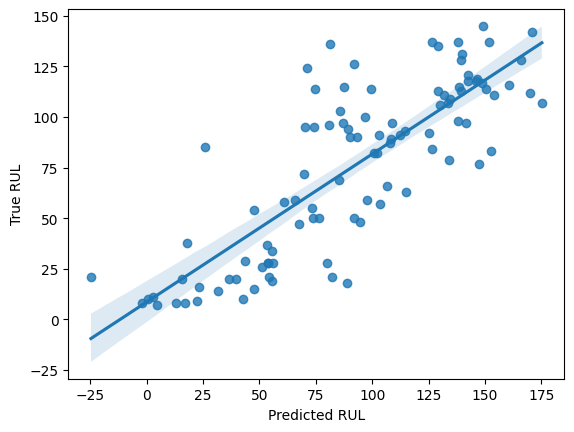

In [95]:

# Visualisation de la relation entre le RUL prédit et le RUL réel
sns.regplot(x=y_test.Reg_Pred_RUL, y=y_test.RUL)
# Ajouter les labels aux axes
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

# Afficher le graphique
plt.show()


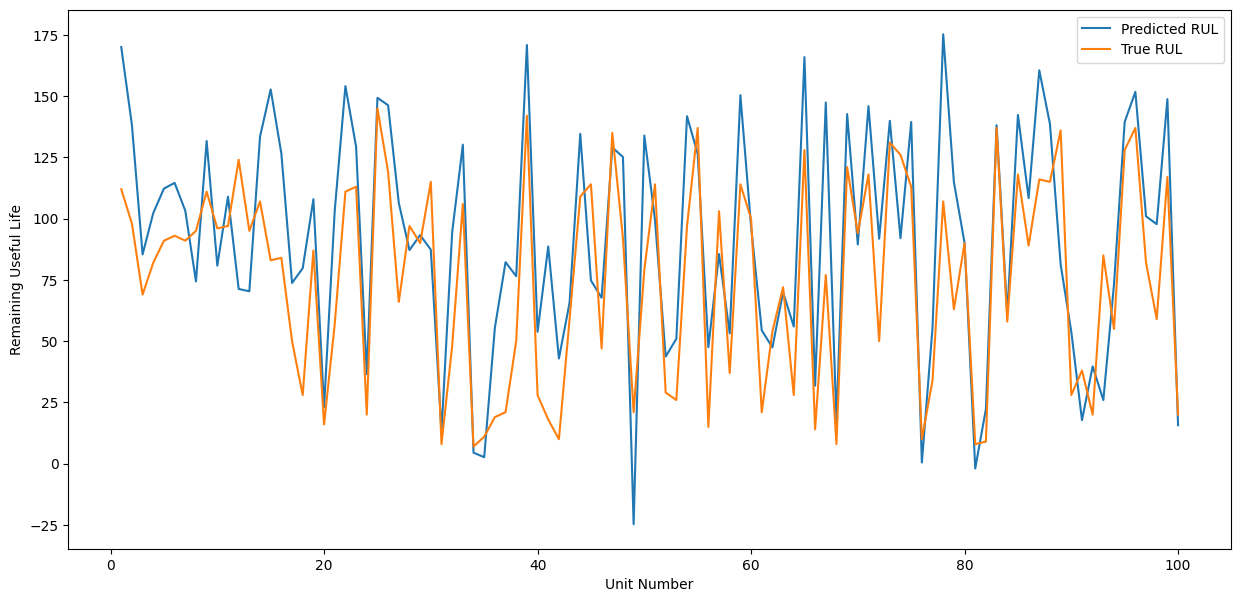

In [96]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_test.engine, y = y_test.Reg_Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_test.engine, y = y_test.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score, root_mean_squared_error

In [98]:
rmse=root_mean_squared_error(y_test.RUL, y_test.Reg_Pred_RUL)
rmse

np.float64(31.360770885321514)

In [99]:
mae=mean_absolute_error(y_test.RUL, y_test.Reg_Pred_RUL)
mae

np.float64(26.071619990155746)

In [100]:
r_2=r2_score(y_test.RUL, y_test.Reg_Pred_RUL)
r_2

0.4304735282145046

# random forest

In [101]:
from sklearn.ensemble import RandomForestRegressor
model_forest = RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=8)
model_forest.fit(X_train , y_train)

y_pred = model_forest.predict(X_train)
metrics(y_train , y_pred , label = 'train')

y_test['Random_Pred_RUL'] = model_forest.predict(X_test)
metrics(y_test.RUL , y_test.Random_Pred_RUL , label = 'test')

for train set , RMSE = 30.02 , r2_score = 81.00%
for test set , RMSE = 25.32 , r2_score = 62.88%


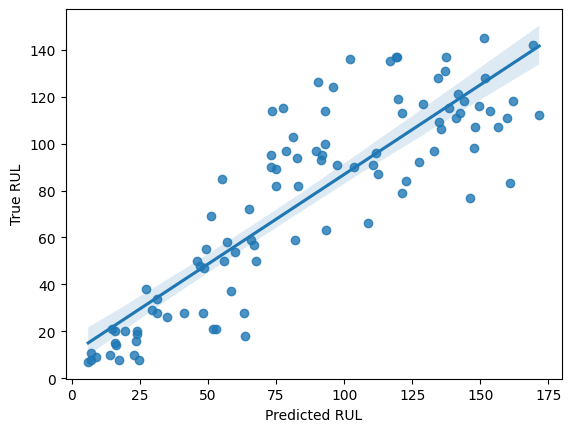

In [102]:

# Visualisation de la relation entre le RUL prédit et le RUL réel
sns.regplot(x=y_test.Random_Pred_RUL, y=y_test.RUL)
# Ajouter les labels aux axes
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

# Afficher le graphique
plt.show()


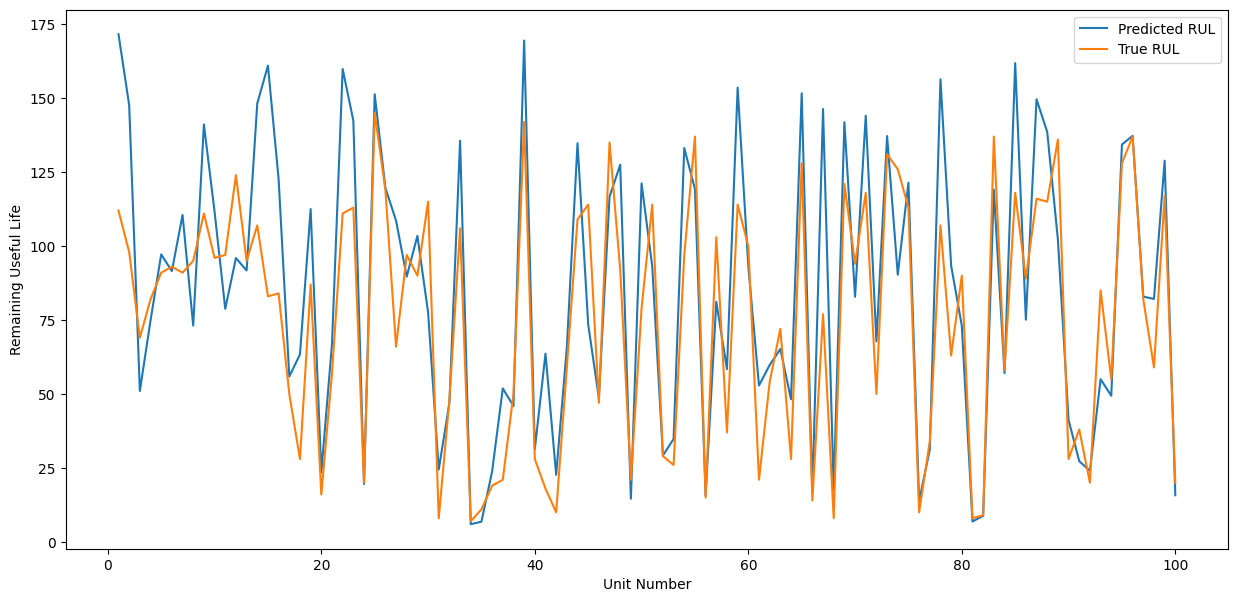

In [103]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_test.engine, y = y_test.Random_Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_test.engine, y = y_test.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [104]:
rmse=root_mean_squared_error(y_test.RUL, y_test.Random_Pred_RUL)
rmse

np.float64(25.316876545506894)

In [105]:
mae=mean_absolute_error(y_test.RUL, y_test.Random_Pred_RUL)
mae

np.float64(19.1730230475927)

In [106]:
r_2=r2_score(y_test.RUL, y_test.Random_Pred_RUL)
r_2

0.6288403953486487

# SVM

In [107]:
%%time
from sklearn.svm import SVR
model_svm = SVR()
model_svm.fit(X_train , y_train)

y_pred = model_svm.predict(X_train)
metrics(y_train , y_pred , label = 'train')

y_test['SVM_Pred_RUL'] = model_svm.predict(X_test)
metrics(y_test.RUL , y_test.SVM_Pred_RUL , label = 'test')

for train set , RMSE = 37.85 , r2_score = 69.80%
for test set , RMSE = 24.91 , r2_score = 64.06%
CPU times: total: 2min 28s
Wall time: 2min 44s


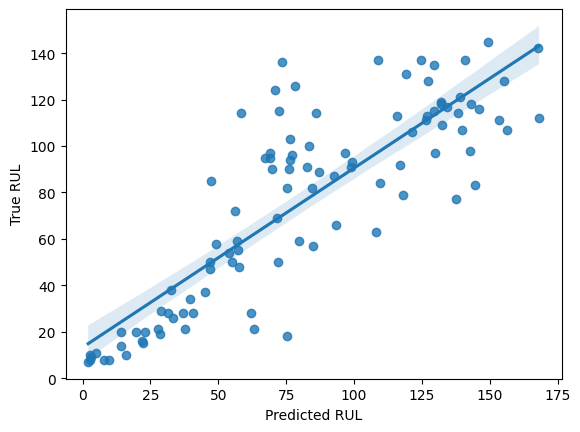

In [108]:

# Visualisation de la relation entre le RUL prédit et le RUL réel
sns.regplot(x=y_test.SVM_Pred_RUL, y=y_test.RUL)
# Ajouter les labels aux axes
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

# Afficher le graphique
plt.show()


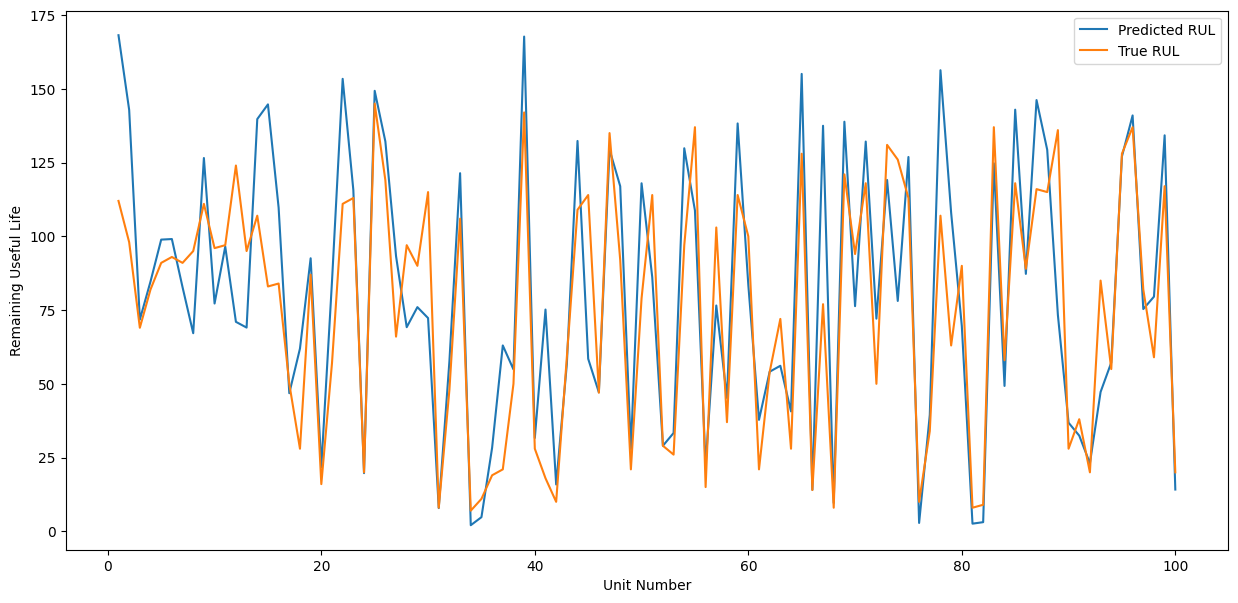

In [109]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_test.engine, y = y_test.SVM_Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_test.engine, y = y_test.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [110]:
rmse=root_mean_squared_error(y_test.RUL, y_test.SVM_Pred_RUL)
rmse

np.float64(24.91375756155062)

In [111]:
mae=mean_absolute_error(y_test.RUL, y_test.SVM_Pred_RUL)
mae

np.float64(18.489384854010083)

In [112]:
r_2=r2_score(y_test.RUL, y_test.SVM_Pred_RUL)
r_2

0.6405661922384175

In [113]:
#prepare data for powerBI
engine_id=10

In [122]:
test_data_bi=test_data[test_data["engine"]==engine_id].drop(columns=["engine"])
scaled_test_data_bi = scaler.transform(test_data_bi) 

In [123]:
SVM_RUL_10=model_linreg.predict(scaled_test_data_bi)

In [128]:
test_data_bi["svm_rul"]=SVM_RUL_10
test_data_bi=test_data_bi[["time","svm_rul"]]
test_data_bi

,time,svm_rul
896,1,184.731778
897,2,200.078457
898,3,206.391967
899,4,173.270650
900,5,181.539625
...,...,...
1083,188,86.767475
1084,189,75.917463
1085,190,92.393537
1086,191,87.933207


In [130]:
test_data_bi.to_csv("../BI/test_engine.csv")